In [178]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import scipy.sparse
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

import pickle

In [228]:
df_train_modify = pd.read_csv('../../app/bike_app/static/csv/train_modifie.csv')
df_test_modify = pd.read_csv('../../app/bike_app/static/csv/test_modifie.csv')

df_train = df_train_modify.drop(['day_length', 'day_light'], axis=1)
df_test = df_test_modify.drop(['day_length', 'day_light'], axis=1)

In [229]:
X_train = df_train.drop(['registered', 'casual'], axis=1)
y_train_registered = df_train['registered']
y_train_casual = df_train['casual']

X_test = df_test.drop(['registered', 'casual'], axis=1)
y_test_registered = df_test['registered']
y_test_casual = df_test['casual']

In [230]:
X_train_registered, _, y_train_registered, _ = train_test_split(X_train, y_train_registered, test_size=0.00001)
X_train_casual, _, y_train_casual, _ = train_test_split(X_train, y_train_casual, test_size=0.00001)

In [231]:
with open('../../app/bike_app/static/pickle/model_registered.pkl', 'rb') as file:
        model_registered_xgboost = pickle.load(file)
with open('../../app/bike_app/static/pickle/model_registered_linear.pkl', 'rb') as file:
        model_registered_linear = pickle.load(file)
with open('../../app/bike_app/static/pickle/model_casual.pkl', 'rb') as file:
        model_casual_xgboost = pickle.load(file)
with open('../../app/bike_app/static/pickle/model_casual_linear.pkl', 'rb') as file:
        model_casual_linear = pickle.load(file)

In [232]:
#Features et pipelines
encoded_features = ['season', 'weather', 'week_days', 'months']
scaled_features = ['temp', 'atemp', 'windspeed', 'humidity', 'years']#, 'day_length'
preprocessor = make_column_transformer((OneHotEncoder(sparse=False),encoded_features), remainder='passthrough')#(MinMaxScaler(), scaled_features),

preprocessor.fit(X_train_registered)
X_train_preprocessor = preprocessor.transform(X_train_registered)
X_train_registered = pd.DataFrame(X_train_preprocessor)

preprocessor.fit(X_train_casual)
X_train_preprocessor = preprocessor.transform(X_train_casual)
X_train_casual = pd.DataFrame(X_train_preprocessor)

X_test_preprocessor = preprocessor.transform(X_test)
X_test = pd.DataFrame(X_test_preprocessor)

In [233]:
features_name = {}
for i in range(X_train_registered.shape[1]):
    features_name[i] = preprocessor.get_feature_names_out()[i].replace("onehotencoder__","") \
                                                              .replace("remainder__","") \
                                                              .replace("standardscaler__", "") \
                                                              .replace('minmaxscaler__', '')
X_train_registered = X_train_registered.rename(columns=features_name)
X_train_casual = X_train_casual.rename(columns=features_name)
X_test = X_test.rename(columns=features_name)

In [234]:
final_estimator = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=6))
model_stacking_registered = StackingRegressor([('lg_registered', model_registered_linear),
                                    ('xgb_registered', model_registered_xgboost)],
                                    final_estimator=final_estimator)

In [235]:
model_stacking_registered.fit(X_train_registered,y_train_registered)
pred_registered = model_stacking_registered.predict(X_test)
model_stacking_registered.score(X_test,y_test_registered)

0.8780362245017757

In [236]:
pred_registered = pd.DataFrame(pred_registered)
pred_registered = pred_registered.rename(columns={0:'prediction'})
X_registered = X_test.join(pred_registered)

<AxesSubplot:xlabel='hours', ylabel='prediction'>

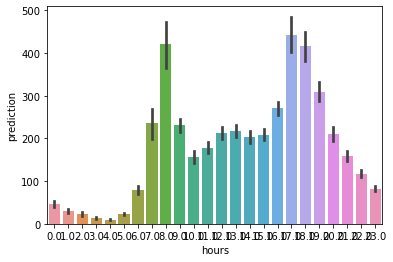

In [237]:
sns.barplot(x='hours', y='prediction', data=X_registered)

In [238]:
import pickle
  
with open('../../app/bike_app/static/pickle/model_registered_stacking.pkl', 'wb') as file:
    pickle.dump(model_stacking_registered, file)

In [239]:
final_estimator = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=7))
model_stacking_casual = StackingRegressor([('lg_casual', model_casual_linear),
                                    ('xgb_casual', model_casual_xgboost)],
                                    final_estimator=final_estimator)

In [240]:
model_stacking_casual.fit(X_train_casual,y_train_casual)
pred = model_stacking_casual.predict(X_test)
model_stacking_casual.score(X_test,y_test_casual)

0.8633253334195502

In [241]:
pred = pd.DataFrame(pred)
pred = pred.rename(columns={0:'prediction'})
X = X_test.join(pred)

<AxesSubplot:xlabel='hours', ylabel='prediction'>

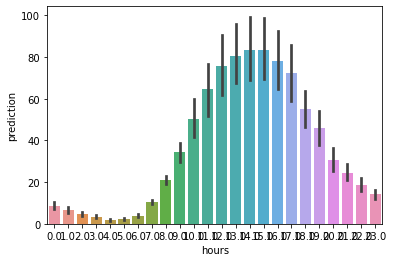

In [242]:
sns.barplot(x='hours', y='prediction', data=X)

In [ ]:
model_stacking_casual

In [243]:
import pickle
  
with open('../../app/bike_app/static/pickle/model_casual_stacking.pkl', 'wb') as file:
    pickle.dump(model_stacking_casual, file)

# Fonctions pour charger données API et les mettre en forme

In [14]:
from datetime import datetime
import json
import requests

api_key = '162a9846bb68bd69f226b05f204e6404'
lat = 50.62925
long = 3.057256

def load_dataAPI(lat, long, api_key):
     url = 'https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&appid={}'.format(lat, long, api_key)
     req = requests.get(url)
     req = req.content.decode("utf-8")
     return json.loads(req)

def get_48h_data(dataAPI, feature_names):
    dataAPI = [dataAPI[i] for i in range(len(dataAPI))]
    data = []
    for dict in dataAPI:
        data.append(data_formatting(dict, feature_names))
    return f'{data}'

def get_encoded_features_name(data, features_to_encode):
    data = data.drop(['casual', 'registered'], axis=1)
    ohe = make_column_transformer((OneHotEncoder(), features_to_encode), remainder='passthrough')
    ohe.fit(data)
    data_ohe = ohe.transform(data)
    data = pd.DataFrame(data_ohe)
    # On récupère le nom des colonnes après avoir OneHotEncodé
    features_name = {}
    for i in range(data.shape[1]):
        features_name[i] = ohe.get_feature_names_out()[i].replace("onehotencoder__","").replace("remainder__","")
    data = data.rename(columns=features_name)
    return data.columns

def data_formatting(data_1h_API, feature_names):
    # keys correspond aux clés du dataset après onehotencodage

    # On extrait les données nécessaires pour la prédiction
    timestamp = data_1h_API['dt']
    data_1h_API['dt'] = datetime.fromtimestamp(data_1h_API['dt'])
    data_1h_API['weather'] = data_1h_API['weather'][0]['id']

    # Reformatage des données issues de l'API en une forme qui nous convient
    keys = ['dt', 'temp', 'feels_like', 'humidity', 'wind_speed', 'weather']
    new_keys = ['dt', 'temp', 'atemp', 'humidity', 'windspeed', 'weather']
    data = {}
    for key, new_key in zip(keys, new_keys):
        data[new_key] = data_1h_API[key]
    data['temp'] = round(data['temp'] - 273.15, 2)
    data['atemp'] = round(data['atemp'] - 273.15, 2)

    # Création d'un dictionnaire avec les clés correspondant aux noms des features utilisées
    # lors de la modélisation donc encodées.
    data_1h_dict = {}
    for name in feature_names:
        data_1h_dict[name] = 0

    for key in data.keys():
        data_1h_dict[key] = data[key]

    data_1h_dict = get_weather(data_1h_dict)

    data_1h_dict['hours'] = data_1h_dict['dt'].hour
    data_1h_dict['years'] = data_1h_dict['dt'].year
    data_1h_dict = get_months(data_1h_dict)
    data_1h_dict, weekday = get_week_day(data_1h_dict, timestamp)

    data_1h_dict = get_season(data_1h_dict)
    data_1h_dict = get_workingday(data_1h_dict, weekday)
    data_1h_dict['dt'] = data_1h_dict['dt'].strftime("%A, %Y-%m-%d, %H:%M:%S")

    return data_1h_dict

def feels_like_temperature(temp,humidity):
    # Heat index (indice de chaleur) ; en degré celsius
    c1 = -8.78469475556
    c2 = 1.61139411
    c3 = 2.33854883889
    c4 = -0.14611605
    c5 = -0.012308094
    c6 = -0.0164248277778
    c7 = 2.211732e-3
    c8 = 7.2546e-4
    c9 = 3.582e-6
    T = temp
    R = humidity
    if (humidity > 40) & (temp > 27):
        return c1 + c2*T + c3*R + c4*T*R + c5*pow(T,2) + c6*pow(R,2) + c7*pow(T,2)*R + c8*T*pow(R,2) + c9*pow(T,2)*pow(R,2)
    else:
        return temp

def get_weather(data_1h_dict):
    weather_1 = [800, 801, 802]
    weather_2 = [701, 711, 721, 803, 804]
    weather_3 = [200, 201, 300, 301, 310, 500, 501, 520,
                 600, 601, 611, 612, 615, 620, 731, 741, 751]
    weather_4 = [202, 210, 211, 212, 221, 230, 231, 232,
                 301, 302, 311, 312, 313, 314, 321, 502,
                 503, 504, 511, 520, 521, 522, 531, 602,
                 613, 616, 621, 622, 761, 762, 771, 781]
    weathers = [weather_1, weather_2, weather_3, weather_4]
    weather_labels = ['weather_1', 'weather_2', 'weather_3', 'weather_4']
    for i, weather in enumerate(weathers):
        if data_1h_dict['weather'] in weather:
            data_1h_dict[weather_labels[i]] = 1
    data_1h_dict.pop('weather')
    return data_1h_dict

def get_season(data_1h_dict):
    seasons = ['06-21', '09-21', '12-21']
    for i, season in enumerate(seasons):
        if (data_1h_dict['dt'].strftime('%m-%d') < '03-21'):
            data_1h_dict['season_4'] = 1
            return data_1h_dict
        if ((data_1h_dict['dt'].strftime('%m-%d') < season) & (data_1h_dict['dt'].strftime('%m-%d') >= '03-21')):
            data_1h_dict['season_' + str(i+1)] = 1
            return data_1h_dict

def get_months(data_1h_dict):
    month = data_1h_dict['dt'].month
    month_label = 'months_' + str(month)
    data_1h_dict[month_label] = 1
    return data_1h_dict

def get_week_day(data_1h_dict, timestamp):
    weekday = datetime.fromtimestamp(timestamp).weekday()+1
    weekday_label = 'week_days_' + str(weekday)
    data_1h_dict[weekday_label] = 1
    return data_1h_dict, weekday

def get_workingday(data_1h_dict, weekday):
    if (weekday >= 6):
        data_1h_dict['workingday'] = 0
    else:
        data_1h_dict['workingday'] = 1
    return data_1h_dict


# Fit données API

In [244]:
features_to_encode = ['season', 'weather', 'week_days', 'months']
feature_names = get_encoded_features_name(df_train, features_to_encode)
dataAPI = dataAPI = load_dataAPI(lat, long, api_key)

data = get_48h_data(dataAPI['hourly'], feature_names)

In [27]:
pd.set_option('display.max_columns', None)
data.head(1)

,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,week_days_1,week_days_2,week_days_3,week_days_4,week_days_5,week_days_6,week_days_7,months_1,months_2,months_3,months_4,months_5,months_6,months_7,months_8,months_9,months_10,months_11,months_12,holiday,workingday,temp,atemp,humidity,windspeed,hours,years,dt
0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,9.2,5.08,64,10.35,21,2022,"Thursday, 2022-04-07, 21:00:00"


In [245]:
data = pd.DataFrame(eval(data))
pred_registered = list(model_stacking_registered.predict(data))

pred_registered = pd.DataFrame(pred_registered)
pred_registered = pred_registered.rename(columns={0: 'prediction'})
# data = data['hours'].reset_index()

In [246]:
pred_registered

,prediction
0,104.000000
1,83.333333
2,46.000000
3,20.166667
4,15.500000
5,10.000000
6,5.500000
7,22.166667
8,81.666667
9,257.500000
